In [1]:
#!/usr/bin/python3.8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import seaborn as sns
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.signal import find_peaks
# import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
# ================= CONSTANTS =================
PMT_PULSE_LENGTH = 1500  # Sample lenght of a typical pulse

# Loading dataset

In [3]:
#No normalization is required
#Loading isolated pulses (not long traces)
df = pd.read_csv("../PeakDetection_Na22_IndividualPulses2kV_v4_t100.csv", index_col = 0)
df = df.T

In [27]:
df

0     1     2     3     4     5     6     7     8     9     ...  1490  \
0        135   136   137   136   139   136   137   136   137   136  ...   137   
1        136   136   136   137   138   136   137   137   137   137  ...   137   
2        136   135   136   136   137   135   136   137   137   136  ...   137   
3        137   137   137   137   139   137   138   137   138   137  ...   138   
4        138   136   137   136   139   137   137   137   137   136  ...   137   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
157034    14    21    48    57    59    49    43    35    41    58  ...   137   
157035   137   137   137   138   139   138   138   136   138   137  ...   138   
157036   138   137   138   137   139   137   138   137   138   137  ...   138   
157037   137   138   137   137   139   137   138   137   138   137  ...   138   
157038   137   137   138   137   139   137   138   137   137   137  ...   138   

        1491  1492  1493  1494  1495  1496  1497  1498  1499  
0        136   138   137   137   137   137   137   137   136  
1        136   138   137   137   136   130   123   122   127  
2        137   137   137   137   137   137   136   137   138  
3        137   137   137   137   136   138   137   138   137  
4        137   137   137   138   137   137   137   137   136  
...      ...   ...   ...   ...   ...   ...   ...   ...   ...  
157034   137   137   137   137   137   137   137   137   137  
157035   137   138   138   138   137   137   137   138   136  
157036   136   138   137   138   137   138   137   138   137  
157037   137   137   136   137   136   137   137   138   137  
157038   136   138   138   138   137   138   137   137   137  

[157039 rows x 1500 columns]

# Peak detection and valid pulse filtering algorithms

In [5]:
def pkdetect(x, thr=100, pkh=10):
    peak=[]
    lmax=0
    imax=0
    count=0
    for i in range(1,len(x)):
        if x[i] <= thr:
            pass
        elif x[i] > lmax:
            imax=i
            lmax=x[i]
        elif ((lmax-x[i-1]) > pkh) and (x[i]-x[i-1])>0:
            peak.append(imax)
            lmax=0
        else:
            pass
            
    return peak

In [6]:
def validPulse(x, initThrs = 5, lookForPeakWindow = 10, windowSize = 200, thrshldRatios = 1.25):

    #Check if a high peak pulse is detected at the beginning
    
    partValid = 0
    for i in range(lookForPeakWindow):
        if x[i] > initThrs:
            partValid = 1
#             print("Valid initial peak")
            
    #Is this a decreasing "typical" pulse?
    if partValid:
        initAvg = sum(x[windowSize:]) / windowSize
        endAvg = sum(x[:windowSize]) / windowSize
#         print("Average ratios: " + str(initAvg / endAvg))
        if (initAvg / endAvg) > thrshldRatios:
            return 1
        
    return 0

        

# Filtering only valid typical pulses

### Remove baseline frist

In [7]:
df2 = pd.DataFrame()

In [8]:
for i in range(len(df.T)):
    df2[i] = df.max(axis = 1)[i] - df[i]
df2

0     1     2     3     4     5     6     7     8     9     ...  1490  \
0          4     2     1     3     0     3     2     3     2     3  ...     2   
1          3     2     2     2     1     3     2     2     2     2  ...     2   
2          3     3     2     3     2     4     3     2     2     3  ...     2   
3          2     1     1     2     0     2     1     2     1     2  ...     1   
4          1     2     1     3     0     2     2     2     2     3  ...     2   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
157034   125   117    90    82    80    90    96   104    98    81  ...     2   
157035     2     1     1     1     0     1     1     3     1     2  ...     1   
157036     1     1     0     2     0     2     1     2     1     2  ...     1   
157037     2     0     1     2     0     2     1     2     1     2  ...     1   
157038     2     1     0     2     0     2     1     2     2     2  ...     1   

        1491  1492  1493  1494  1495  1496  1497  1498  1499  
0          3     1     2     2     2     2     2     2     3  
1          3     1     2     2     3     9    16    17    12  
2          2     2     2     2     2     2     3     2     1  
3          2     2     2     2     3     1     2     1     2  
4          2     2     2     1     2     2     2     2     3  
...      ...   ...   ...   ...   ...   ...   ...   ...   ...  
157034     2     2     2     2     2     2     2     2     2  
157035     2     1     1     1     2     2     2     1     3  
157036     3     1     2     1     2     1     2     1     2  
157037     2     2     3     2     3     2     2     1     2  
157038     3     1     1     1     2     1     2     2     2  

[157039 rows x 1500 columns]

### Apply pulse validation algorithm

In [9]:
df2["ValidPulse"] = df2.apply(validPulse, axis = 1)
df2

0    1   2   3   4   5   6    7   8   9  ...  1491  1492  1493  \
0         4    2   1   3   0   3   2    3   2   3  ...     3     1     2   
1         3    2   2   2   1   3   2    2   2   2  ...     3     1     2   
2         3    3   2   3   2   4   3    2   2   3  ...     2     2     2   
3         2    1   1   2   0   2   1    2   1   2  ...     2     2     2   
4         1    2   1   3   0   2   2    2   2   3  ...     2     2     2   
...     ...  ...  ..  ..  ..  ..  ..  ...  ..  ..  ...   ...   ...   ...   
157034  125  117  90  82  80  90  96  104  98  81  ...     2     2     2   
157035    2    1   1   1   0   1   1    3   1   2  ...     2     1     1   
157036    1    1   0   2   0   2   1    2   1   2  ...     3     1     2   
157037    2    0   1   2   0   2   1    2   1   2  ...     2     2     3   
157038    2    1   0   2   0   2   1    2   2   2  ...     3     1     1   

        1494  1495  1496  1497  1498  1499  ValidPulse  
0          2     2     2     2     2     3           0  
1          2     3     9    16    17    12           0  
2          2     2     2     3     2     1           0  
3          2     3     1     2     1     2           0  
4          1     2     2     2     2     3           0  
...      ...   ...   ...   ...   ...   ...         ...  
157034     2     2     2     2     2     2           0  
157035     1     2     2     2     1     3           0  
157036     1     2     1     2     1     2           0  
157037     2     3     2     2     1     2           0  
157038     1     2     1     2     2     2           0  

[157039 rows x 1501 columns]

In [10]:
dfPulses = df2.loc[df2["ValidPulse"] > 0]
dfPulses = dfPulses.drop("ValidPulse", axis = 1)
dfPulses

0     1     2     3     4     5     6     7     8     9     ...  1490  \
7         41    30    30    25    15    22    41    63    91    91  ...     2   
10         1     2    44    34    30    37    53    70    71    88  ...     2   
11         6     3     2     4     1     3     2     3     2     3  ...     1   
12        11     6     2     5     2     2    11    18    14    11  ...     1   
40         2     2     2     3     1     4    14    20    14    12  ...     2   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
156991    26    19    14     9     7     8    18    31    29    21  ...     1   
156993    10     6     6     4     3     3     3    10    19    19  ...     2   
157015    58    36    31    18    11    12    21    26    33    39  ...     2   
157019     7     6     3     3     2     4     2     3     9    16  ...     2   
157021     3     2     1     3     1     3     3    15    27    28  ...     1   

        1491  1492  1493  1494  1495  1496  1497  1498  1499  
7          2     2     2     2     2     2     2     3     2  
10         2     1     2     2     4     6     9    22    37  
11         2     1     2     1     2     1     2     2     2  
12         2     2     3     1     3     1     2     1     2  
40         2     2     3     2     3     1     3     1     3  
...      ...   ...   ...   ...   ...   ...   ...   ...   ...  
156991     2     2     2     1     3     2     2     2     2  
156993     1     2     1     2     1     2     1     2     1  
157015     1     3     2     3     2     2     1     1     1  
157019     3     2     3     2     2     2     3     1     2  
157021     2     2     2     2     3     1     2     2     2  

[24386 rows x 1500 columns]

# ===== DEBUGGING TEST - DO NOT RUN =======

In [34]:
samplePulse = dfPulses.iloc[20]
samplePulse

0                                                                   6
1                                                                  12
2                                                                  14
3                                                                  11
4                                                                  10
                                          ...                        
1498                                                                2
1499                                                                2
peakLocations       [6, 13, 22, 28, 40, 54, 86, 108, 136, 158, 174...
arrivalTimes        [7, 16, 22, 34, 48, 80, 102, 130, 152, 168, 17...
timeBetweenPeaks    [7, 9, 6, 12, 14, 32, 22, 28, 22, 16, 9, 11, 1...
Name: 177, Length: 1503, dtype: object

<IPython.core.display.Javascript object>


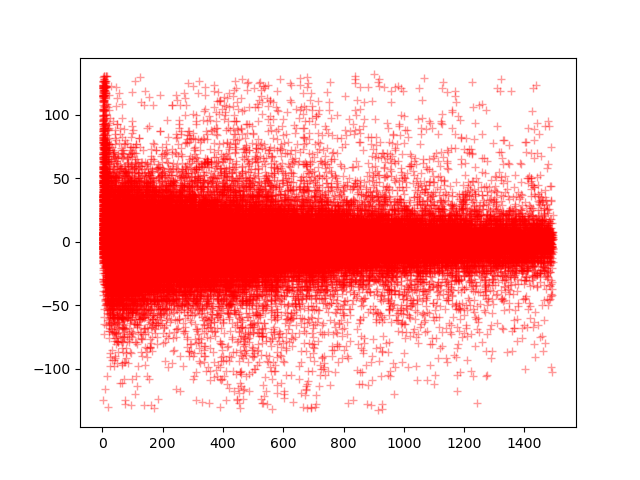

In [64]:
%matplotlib notebook
x = samplePulse.loc["peakLocations"]
y = samplePulse[x]

BASELINE_SHIFT = 2

for i in range(1000):
    samplePulse = dfPulses.iloc[i]
    x = samplePulse.loc["peakLocations"]
    y = []
    
    
    for j in range(len(x)):
        y.append(samplePulse[x[j]] - samplePulse[x[j - BASELINE_SHIFT]])
    
    plt.plot(x,y, 'r+', alpha = 0.4)

plt.show()

In [28]:
dfPulses

0   1   2   3   4   5   6   7   8   9  ...  1493  1494  1495  1496  \
7       41  30  30  25  15  22  41  63  91  91  ...     2     2     2     2   
10       1   2  44  34  30  37  53  70  71  88  ...     2     2     4     6   
11       6   3   2   4   1   3   2   3   2   3  ...     2     1     2     1   
12      11   6   2   5   2   2  11  18  14  11  ...     3     1     3     1   
40       2   2   2   3   1   4  14  20  14  12  ...     3     2     3     1   
...     ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...   ...   ...   ...   ...   
156991  26  19  14   9   7   8  18  31  29  21  ...     2     1     3     2   
156993  10   6   6   4   3   3   3  10  19  19  ...     1     2     1     2   
157015  58  36  31  18  11  12  21  26  33  39  ...     2     3     2     2   
157019   7   6   3   3   2   4   2   3   9  16  ...     3     2     2     2   
157021   3   2   1   3   1   3   3  15  27  28  ...     2     2     3     1   

        1497  1498  1499                                      peakLocations  \
7          2     3     2  [1, 8, 23, 26, 31, 39, 66, 69, 94, 117, 122, 1...   
10         9    22    37  [2, 11, 22, 32, 41, 51, 55, 73, 76, 80, 93, 10...   
11         2     2     2  [19, 50, 72, 114, 143, 173, 184, 239, 266, 350...   
12         2     1     2                                      [7, 195, 273]   
40         3     1     3  [7, 37, 161, 221, 267, 361, 373, 399, 408, 443...   
...      ...   ...   ...                                                ...   
156991     2     2     2  [1, 7, 13, 26, 31, 40, 49, 54, 57, 68, 74, 83,...   
156993     1     2     1  [13, 18, 22, 31, 42, 64, 99, 121, 139, 164, 17...   
157015     1     1     1  [1, 13, 21, 31, 39, 45, 57, 61, 71, 80, 91, 11...   
157019     3     1     2  [13, 65, 138, 154, 169, 185, 212, 253, 335, 36...   
157021     2     2     2  [9, 22, 29, 35, 195, 360, 370, 392, 403, 556, ...   

                                             arrivalTimes  \
7       [7, 22, 25, 30, 38, 65, 68, 93, 116, 121, 129,...   
10      [9, 20, 30, 39, 49, 53, 71, 74, 78, 91, 98, 11...   
11      [31, 53, 95, 124, 154, 165, 220, 247, 331, 367...   
12                                             [188, 266]   
40      [30, 154, 214, 260, 354, 366, 392, 401, 436, 4...   
...                                                   ...   
156991  [6, 12, 25, 30, 39, 48, 53, 56, 67, 73, 82, 98...   
156993  [5, 9, 18, 29, 51, 86, 108, 126, 151, 160, 196...   
157015  [12, 20, 30, 38, 44, 56, 60, 70, 79, 90, 111, ...   
157019  [52, 125, 141, 156, 172, 199, 240, 322, 350, 3...   
157021  [13, 20, 26, 186, 351, 361, 383, 394, 547, 640...   

                                         timeBetweenPeaks  
7       [7, 15, 3, 5, 8, 27, 3, 25, 23, 5, 8, 7, 17, 6...  
10      [9, 11, 10, 9, 10, 4, 18, 3, 4, 13, 7, 15, 8, ...  
11      [31, 22, 42, 29, 30, 11, 55, 27, 84, 36, 18, 5...  
12                                              [188, 78]  
40      [30, 124, 60, 46, 94, 12, 26, 9, 35, 28, 154, ...  
...                                                   ...  
156991  [6, 6, 13, 5, 9, 9, 5, 3, 11, 6, 9, 16, 5, 9, ...  
156993  [5, 4, 9, 11, 22, 35, 22, 18, 25, 9, 36, 46, 8...  
157015  [12, 8, 10, 8, 6, 12, 4, 10, 9, 11, 21, 8, 16,...  
157019  [52, 73, 16, 15, 16, 27, 41, 82, 28, 15, 17, 2...  
157021  [13, 7, 6, 160, 165, 10, 22, 11, 153, 93, 7, 1...  

[23979 rows x 1503 columns]

In [26]:
%matplotlib notebook
dfPulses.iloc[1000:1010,:].T.plot()
plt.show()

TypeError: no numeric data to plot

In [12]:
import random
randPulse = random.randrange(1000)
randPulse

355

<IPython.core.display.Javascript object>


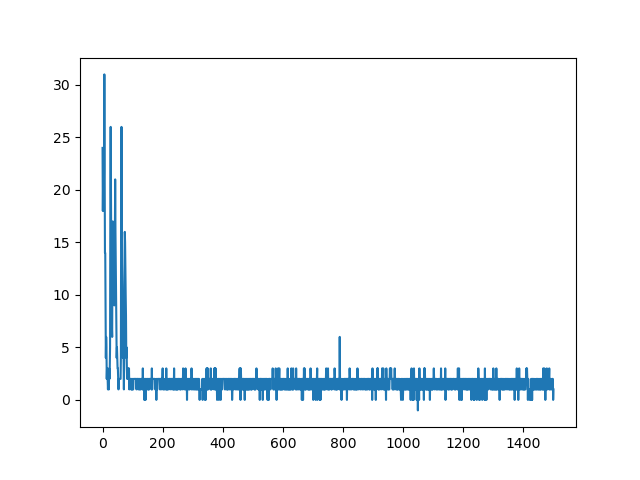

Valid: 1


In [13]:
%matplotlib notebook
sample = df2.iloc[randPulse,:]
sample.plot()
plt.show()
print("Valid: "+ str(validPulse(sample, 5, 10, 200, 1.25)))

# ===== DEBUGGING ENDS HERE :) =======

# Peaks sequence detection

In [66]:
import random
randPulse = random.randrange(1000)
randPulse

709

In [77]:
# Peak time distribution
samplePulse = dfPulses.iloc[randPulse]
samplePulse = samplePulse[:1500]
samplePulse["peakLocations"] = pkdetect(samplePulse, 4, 1)
samplePulse

0                                                               79
1                                                               63
2                                                               58
3                                                               63
4                                                               47
                                       ...                        
1496                                                             1
1497                                                             2
1498                                                             1
1499                                                             3
peakLocations    [1, 6, 13, 20, 23, 29, 35, 41, 54, 59, 63, 73,...
Name: 4659, Length: 1501, dtype: object

<IPython.core.display.Javascript object>


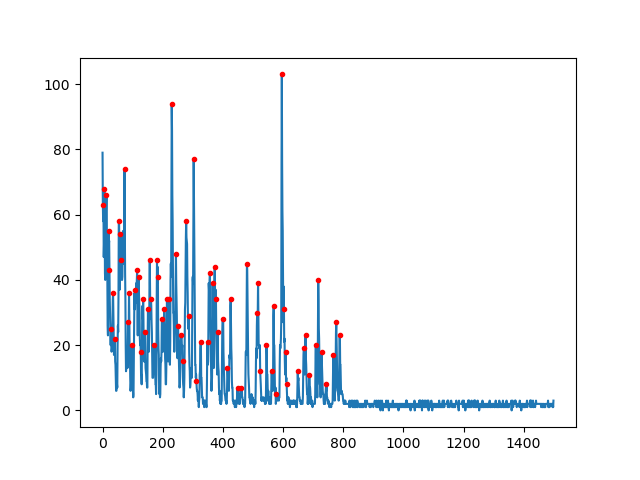

In [78]:
%matplotlib notebook
onlyPulse = samplePulse.iloc[:-1]
peaks = samplePulse.iloc[-1]
ax = onlyPulse.plot()
plt.plot(peaks, onlyPulse[peaks], 'r.')
plt.show()

In [ ]:
a = dfPulses.iloc[:100].copy()
a["peakLocations"] = a.apply(pkdetect, args = (5, 5), axis = 1)
b = a.loc[a["peakLocations"].map(len) > 1]
#b[b.columns[:15]]
c = b.loc[:,"peakLocations"]
c

In [11]:
#Add peak locations column to each pulse
dfPulses["peakLocations"] = dfPulses[dfPulses.columns[:PMT_PULSE_LENGTH]].apply(pkdetect, args = (2, 5), axis = 1)


#Remove pulses with less than 2 peaks
dfPulses = dfPulses.drop(dfPulses.loc[dfPulses["peakLocations"].map(len) < 2].T, axis = 0)
dfPulses

0   1   2   3   4   5   6   7   8   9  ...  1491  1492  1493  1494  \
7       41  30  30  25  15  22  41  63  91  91  ...     2     2     2     2   
10       1   2  44  34  30  37  53  70  71  88  ...     2     1     2     2   
11       6   3   2   4   1   3   2   3   2   3  ...     2     1     2     1   
12      11   6   2   5   2   2  11  18  14  11  ...     2     2     3     1   
40       2   2   2   3   1   4  14  20  14  12  ...     2     2     3     2   
...     ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...   ...   ...   ...   ...   
156991  26  19  14   9   7   8  18  31  29  21  ...     2     2     2     1   
156993  10   6   6   4   3   3   3  10  19  19  ...     1     2     1     2   
157015  58  36  31  18  11  12  21  26  33  39  ...     1     3     2     3   
157019   7   6   3   3   2   4   2   3   9  16  ...     3     2     3     2   
157021   3   2   1   3   1   3   3  15  27  28  ...     2     2     2     2   

        1495  1496  1497  1498  1499  \
7          2     2     2     3     2   
10         4     6     9    22    37   
11         2     1     2     2     2   
12         3     1     2     1     2   
40         3     1     3     1     3   
...      ...   ...   ...   ...   ...   
156991     3     2     2     2     2   
156993     1     2     1     2     1   
157015     2     2     1     1     1   
157019     2     2     3     1     2   
157021     3     1     2     2     2   

                                            peakLocations  
7       [1, 8, 23, 26, 31, 39, 66, 69, 94, 117, 122, 1...  
10      [2, 11, 22, 32, 41, 51, 55, 73, 76, 80, 93, 10...  
11      [19, 50, 72, 114, 143, 173, 184, 239, 266, 350...  
12                                          [7, 195, 273]  
40      [7, 37, 161, 221, 267, 361, 373, 399, 408, 443...  
...                                                   ...  
156991  [1, 7, 13, 26, 31, 40, 49, 54, 57, 68, 74, 83,...  
156993  [13, 18, 22, 31, 42, 64, 99, 121, 139, 164, 17...  
157015  [1, 13, 21, 31, 39, 45, 57, 61, 71, 80, 91, 11...  
157019  [13, 65, 138, 154, 169, 185, 212, 253, 335, 36...  
157021  [9, 22, 29, 35, 195, 360, 370, 392, 403, 556, ...  

[23979 rows x 1501 columns]

### Time between first and Nth peaks

In [12]:
def relativeArrivalTimes(x):
    deltaList = []
    for i in range(len(x) - 1):
        deltaList.append(x[i + 1] - x[0]) #Relative time respect to first peak
    
    return deltaList

### Time between successive peaks

In [13]:
def timeBetweenPeaks(x):
    deltaList = []
    for i in range(len(x) - 1):
        deltaList.append(x[i + 1] - x[i]) #Relative time respect to first peak
    
    return deltaList

In [14]:
dfPulses["arrivalTimes"] = dfPulses["peakLocations"].apply(relativeArrivalTimes)
dfPulses

0   1   2   3   4   5   6   7   8   9  ...  1492  1493  1494  1495  \
7       41  30  30  25  15  22  41  63  91  91  ...     2     2     2     2   
10       1   2  44  34  30  37  53  70  71  88  ...     1     2     2     4   
11       6   3   2   4   1   3   2   3   2   3  ...     1     2     1     2   
12      11   6   2   5   2   2  11  18  14  11  ...     2     3     1     3   
40       2   2   2   3   1   4  14  20  14  12  ...     2     3     2     3   
...     ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...   ...   ...   ...   ...   
156991  26  19  14   9   7   8  18  31  29  21  ...     2     2     1     3   
156993  10   6   6   4   3   3   3  10  19  19  ...     2     1     2     1   
157015  58  36  31  18  11  12  21  26  33  39  ...     3     2     3     2   
157019   7   6   3   3   2   4   2   3   9  16  ...     2     3     2     2   
157021   3   2   1   3   1   3   3  15  27  28  ...     2     2     2     3   

        1496  1497  1498  1499  \
7          2     2     3     2   
10         6     9    22    37   
11         1     2     2     2   
12         1     2     1     2   
40         1     3     1     3   
...      ...   ...   ...   ...   
156991     2     2     2     2   
156993     2     1     2     1   
157015     2     1     1     1   
157019     2     3     1     2   
157021     1     2     2     2   

                                            peakLocations  \
7       [1, 8, 23, 26, 31, 39, 66, 69, 94, 117, 122, 1...   
10      [2, 11, 22, 32, 41, 51, 55, 73, 76, 80, 93, 10...   
11      [19, 50, 72, 114, 143, 173, 184, 239, 266, 350...   
12                                          [7, 195, 273]   
40      [7, 37, 161, 221, 267, 361, 373, 399, 408, 443...   
...                                                   ...   
156991  [1, 7, 13, 26, 31, 40, 49, 54, 57, 68, 74, 83,...   
156993  [13, 18, 22, 31, 42, 64, 99, 121, 139, 164, 17...   
157015  [1, 13, 21, 31, 39, 45, 57, 61, 71, 80, 91, 11...   
157019  [13, 65, 138, 154, 169, 185, 212, 253, 335, 36...   
157021  [9, 22, 29, 35, 195, 360, 370, 392, 403, 556, ...   

                                             arrivalTimes  
7       [7, 22, 25, 30, 38, 65, 68, 93, 116, 121, 129,...  
10      [9, 20, 30, 39, 49, 53, 71, 74, 78, 91, 98, 11...  
11      [31, 53, 95, 124, 154, 165, 220, 247, 331, 367...  
12                                             [188, 266]  
40      [30, 154, 214, 260, 354, 366, 392, 401, 436, 4...  
...                                                   ...  
156991  [6, 12, 25, 30, 39, 48, 53, 56, 67, 73, 82, 98...  
156993  [5, 9, 18, 29, 51, 86, 108, 126, 151, 160, 196...  
157015  [12, 20, 30, 38, 44, 56, 60, 70, 79, 90, 111, ...  
157019  [52, 125, 141, 156, 172, 199, 240, 322, 350, 3...  
157021  [13, 20, 26, 186, 351, 361, 383, 394, 547, 640...  

[23979 rows x 1502 columns]

In [15]:
dfPulses["timeBetweenPeaks"] = dfPulses["peakLocations"].apply(timeBetweenPeaks)
dfPulses

0   1   2   3   4   5   6   7   8   9  ...  1493  1494  1495  1496  \
7       41  30  30  25  15  22  41  63  91  91  ...     2     2     2     2   
10       1   2  44  34  30  37  53  70  71  88  ...     2     2     4     6   
11       6   3   2   4   1   3   2   3   2   3  ...     2     1     2     1   
12      11   6   2   5   2   2  11  18  14  11  ...     3     1     3     1   
40       2   2   2   3   1   4  14  20  14  12  ...     3     2     3     1   
...     ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...   ...   ...   ...   ...   
156991  26  19  14   9   7   8  18  31  29  21  ...     2     1     3     2   
156993  10   6   6   4   3   3   3  10  19  19  ...     1     2     1     2   
157015  58  36  31  18  11  12  21  26  33  39  ...     2     3     2     2   
157019   7   6   3   3   2   4   2   3   9  16  ...     3     2     2     2   
157021   3   2   1   3   1   3   3  15  27  28  ...     2     2     3     1   

        1497  1498  1499                                      peakLocations  \
7          2     3     2  [1, 8, 23, 26, 31, 39, 66, 69, 94, 117, 122, 1...   
10         9    22    37  [2, 11, 22, 32, 41, 51, 55, 73, 76, 80, 93, 10...   
11         2     2     2  [19, 50, 72, 114, 143, 173, 184, 239, 266, 350...   
12         2     1     2                                      [7, 195, 273]   
40         3     1     3  [7, 37, 161, 221, 267, 361, 373, 399, 408, 443...   
...      ...   ...   ...                                                ...   
156991     2     2     2  [1, 7, 13, 26, 31, 40, 49, 54, 57, 68, 74, 83,...   
156993     1     2     1  [13, 18, 22, 31, 42, 64, 99, 121, 139, 164, 17...   
157015     1     1     1  [1, 13, 21, 31, 39, 45, 57, 61, 71, 80, 91, 11...   
157019     3     1     2  [13, 65, 138, 154, 169, 185, 212, 253, 335, 36...   
157021     2     2     2  [9, 22, 29, 35, 195, 360, 370, 392, 403, 556, ...   

                                             arrivalTimes  \
7       [7, 22, 25, 30, 38, 65, 68, 93, 116, 121, 129,...   
10      [9, 20, 30, 39, 49, 53, 71, 74, 78, 91, 98, 11...   
11      [31, 53, 95, 124, 154, 165, 220, 247, 331, 367...   
12                                             [188, 266]   
40      [30, 154, 214, 260, 354, 366, 392, 401, 436, 4...   
...                                                   ...   
156991  [6, 12, 25, 30, 39, 48, 53, 56, 67, 73, 82, 98...   
156993  [5, 9, 18, 29, 51, 86, 108, 126, 151, 160, 196...   
157015  [12, 20, 30, 38, 44, 56, 60, 70, 79, 90, 111, ...   
157019  [52, 125, 141, 156, 172, 199, 240, 322, 350, 3...   
157021  [13, 20, 26, 186, 351, 361, 383, 394, 547, 640...   

                                         timeBetweenPeaks  
7       [7, 15, 3, 5, 8, 27, 3, 25, 23, 5, 8, 7, 17, 6...  
10      [9, 11, 10, 9, 10, 4, 18, 3, 4, 13, 7, 15, 8, ...  
11      [31, 22, 42, 29, 30, 11, 55, 27, 84, 36, 18, 5...  
12                                              [188, 78]  
40      [30, 124, 60, 46, 94, 12, 26, 9, 35, 28, 154, ...  
...                                                   ...  
156991  [6, 6, 13, 5, 9, 9, 5, 3, 11, 6, 9, 16, 5, 9, ...  
156993  [5, 4, 9, 11, 22, 35, 22, 18, 25, 9, 36, 46, 8...  
157015  [12, 8, 10, 8, 6, 12, 4, 10, 9, 11, 21, 8, 16,...  
157019  [52, 73, 16, 15, 16, 27, 41, 82, 28, 15, 17, 2...  
157021  [13, 7, 6, 160, 165, 10, 22, 11, 153, 93, 7, 1...  

[23979 rows x 1503 columns]

## Relative time between first and Nth peak

<IPython.core.display.Javascript object>


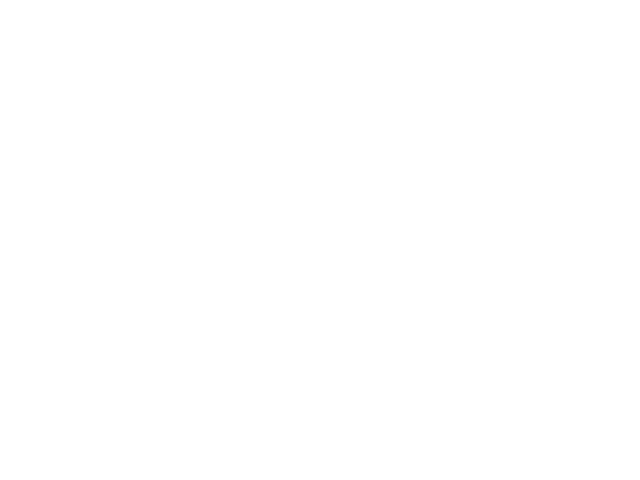

In [16]:
%matplotlib notebook
arrivalTimes = []
for i in dfPulses["arrivalTimes"]:
    arrivalTimes.extend(i)

nBinsFit = int(2*(len(arrivalTimes)**(2/5.0)))
# nBinsFit = 100

histData = plt.hist(arrivalTimes, bins = nBinsFit)
plt.show()

In [17]:
nBinsFit

563

# Model fitting
## Finding parameters of exponential distribution for relative times from first peak

In [18]:
import numpy as np
from scipy.optimize import curve_fit

def expDist(x, A, lamb):
    x = np.array(x)
    return A*np.exp((-1)*lamb*x)

In [19]:
histX = np.array(histData[1][:-1])
histY = np.array(histData[0])

In [20]:
fittingBoundsAmp = (1000, 100000)
fittingBoundsLam = (1e-6, 1.00)

In [21]:
#Using least-squares method
popt, pcov = curve_fit(expDist, histX, histY, bounds = ((fittingBoundsAmp[0], fittingBoundsLam[0]),(fittingBoundsAmp[1], fittingBoundsLam[1])))

distAmp, distLambda = popt

In [22]:
distAmp

5236.150283827309

In [23]:
distLambda

0.0012460057677929027

<IPython.core.display.Javascript object>


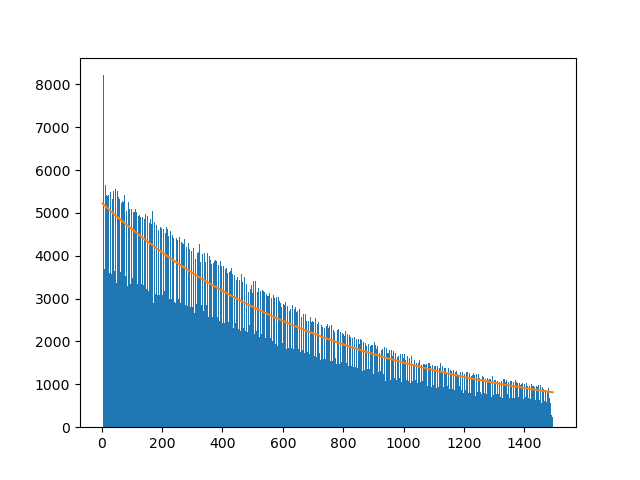

In [24]:
%matplotlib notebook

fitX = histX
fitY = expDist(fitX, distAmp, distLambda)

plt.hist(arrivalTimes, bins = nBinsFit)
plt.plot(fitX, fitY)
plt.show()

In [102]:
len(arrivalTimes)

1569482

In [103]:
a = 0
for i in arrivalTimes:
    if (i < 219 and i > 216):
        a += 1

In [104]:
a

3815

## Finding parameters of exponential distribution for time between succesive peaks (Poisson)

<IPython.core.display.Javascript object>


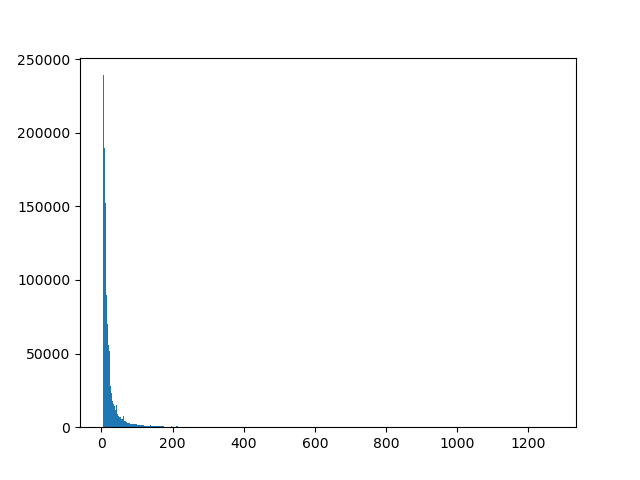

In [105]:
%matplotlib notebook
betweenPulsesTimes = []
for i in dfPulses["timeBetweenPeaks"]:
    betweenPulsesTimes.extend(i)

nBinsFit = int(2*(len(betweenPulsesTimes)**(2/5.0)))
    
histData = plt.hist(betweenPulsesTimes, bins = nBinsFit)
plt.show()

In [106]:
import numpy as np
from scipy.optimize import curve_fit

def expDist(x, A, lamb):
    x = np.array(x)
    return A*np.exp((-1)*lamb*x)

In [107]:
histX = np.array(histData[1][:-1])
histY = np.array(histData[0])

In [111]:
fittingBoundsAmp = (10000, 500000)
fittingBoundsLam = (1e-6, 1.00)

In [115]:
#Using least-squares method
popt, pcov = curve_fit(expDist, histX, histY, bounds = ((fittingBoundsAmp[0], fittingBoundsLam[0]),(fittingBoundsAmp[1], fittingBoundsLam[1])))

distAmp, distLambda = popt

In [116]:
distAmp

328951.51295241097

In [117]:
distLambda

0.08992079516684158

<IPython.core.display.Javascript object>


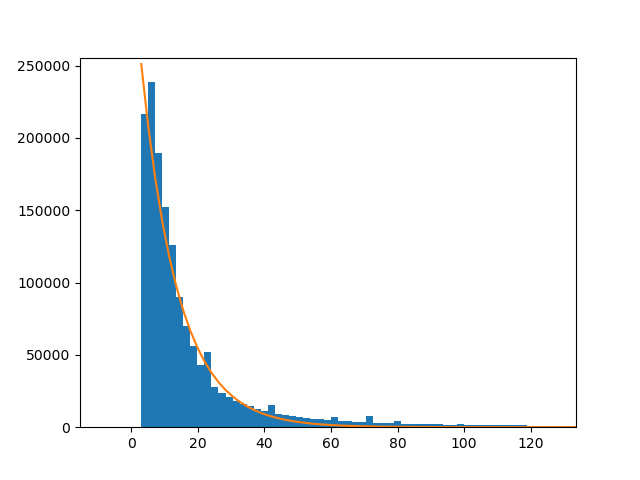

In [118]:
%matplotlib notebook

fitX = histX
fitY = expDist(fitX, distAmp, distLambda)

plt.hist(betweenPulsesTimes, bins = nBinsFit)
plt.plot(fitX, fitY)
plt.show()